Initialize the GCN network

In [ ]:
%load_ext autoreload
%autoreload 2

from model import GNLightning
import torch

if torch.cuda.is_available(): torch.cuda.empty_cache()

model = GNLightning.load_from_checkpoint(
                                    checkpoint_path=r"..\checkpoints\gnet_stage3.ckpt",
                                    d_model=1024,
                                    lr=1e-3,
                                    batch_size=2,
                                    num_workers=0,
                                    train_path=r'..\misc\placeholder.jsonl',
                                    val_path=r'..\misc\placeholder.jsonl')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\remote desktop\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


GNLightning(
  (gnet): GraphNetwork(
    (conv1): GCNConv(256, 1024)
    (conv2): GCNConv(1024, 1024)
    (conv3): GCNConv(1024, 1024)
    (lin1): Linear(in_features=2048, out_features=1024, bias=True)
    (lin_final): Linear(in_features=1024, out_features=3, bias=True)
  )
  (criterion): NLLLoss()
)

Initialize the DETR VIT model

In [ ]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import json
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.ops as ops  # For NMS
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pytorch_lightning import LightningModule
from tqdm.notebook import tqdm
from transformers import DetrForObjectDetection, DetrImageProcessor
from utils import get_iou, state_dict_cleaner, detr2xyxy, xyxy2coco

class Detr(LightningModule):
    def __init__(self, model_name, checkpoint, num_labels):
        super().__init__()

        self.model = DetrForObjectDetection.from_pretrained(model_name, num_labels=num_labels,ignore_mismatched_sizes=True)
        state_dict = torch.load(checkpoint)['state_dict']
        state_dict = state_dict_cleaner(state_dict)
        self.model.load_state_dict(state_dict)

    def forward(self, **inputs):
        return self.model(**inputs)
    

def detr_forward(image_path, model_name, checkpoint, num_labels, iou_threshold=0.8,confidence_threshold=0.5):

    image_processor = DetrImageProcessor.from_pretrained(model_name)
    detr = Detr(
        model_name=model_name,
        checkpoint=checkpoint,
        num_labels=num_labels
    )
    detr.to(device)
    detr.eval()

    # Load and process the batch of images
    image = Image.open(image_path).convert("RGB")
    inputs = image_processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass through the model
    outputs = detr(**inputs)

    logits = outputs.logits[0]  # Shape: (batch_size, num_queries, num_classes)
    pred_boxes = outputs.pred_boxes[0]  # Shape: (num_queries (100) , 4)
    image_width, image_height = image.size  # Get original image dimensions
    pred_boxes = torch.tensor(
        [detr2xyxy(box.cpu().tolist(), image_width, image_height) for box in pred_boxes],
        device=device
    )
    hidden_states = outputs.last_hidden_state[0]  # Shape: (batch_size, num_queries, hidden_dim)

    # as per the docs
    prob = F.softmax(logits, dim=-1)
    scores, _ = prob[..., :-1].max(-1)

    # Filter by confidence threshold
    keep = scores > confidence_threshold
    pred_boxes = pred_boxes[keep]
    hidden_states = hidden_states[keep]
    scores = scores[keep]

    # Apply NMS
    if pred_boxes.shape[0] > 0:
        keep_nms = ops.nms(pred_boxes, scores, iou_threshold)
        pred_boxes = pred_boxes[keep_nms]
        hidden_states = hidden_states[keep_nms]
    
    return pred_boxes.cpu(), hidden_states.cpu()

Run inference on a sample image.
Change the image path to any image that you want.

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

torch.Size([92, 4])


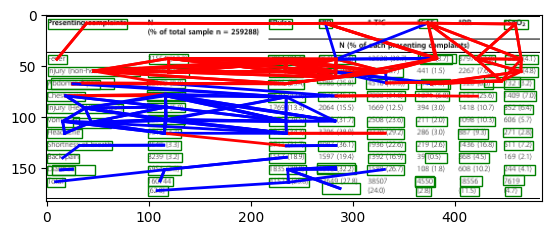

In [ ]:
import json
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

# Constants for classes
CLASS_NONE = 0
CLASS_HORZ = 1
CLASS_VERT = 2

image_path = r"..\misc\PMC4682394_003_00.png"

bboxes, hidden_states = detr_forward(
    image_path=image_path,
    model_name='facebook/detr-resnet-50',
    checkpoint=r'..\checkpoints\detr.ckpt',
    num_labels=64
)
image = Image.open(image_path).convert("RGB")
print(bboxes.shape)
bboxes = torch.tensor([xyxy2coco(bbox) for bbox in bboxes])

probs, edge_index = model(bboxes, hidden_states)
probs, edge_index = probs.to('cpu'), edge_index.to('cpu')

# Step 5: Plotting the bboxes and edges, coloring by predicted class
fig, ax = plt.subplots(1)
ax.imshow(image)

# Plot the bounding boxes
for bbox in bboxes:
    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

# Plot the edges
for i, (start, end) in enumerate(edge_index.t()):
    # Get the centers of the start and end bboxes
    bbox1 = bboxes[start]
    bbox2 = bboxes[end]
    
    x1, y1 = bbox1[0] + bbox1[2] // 2, bbox1[1] + bbox1[3] // 2
    x2, y2 = bbox2[0] + bbox2[2] // 2, bbox2[1] + bbox2[3] // 2
    
    # Get the predicted class for the edge
    predicted_class = torch.argmax(probs[i]).item()
    
    # Set the color based on predicted class
    if predicted_class == CLASS_HORZ:
        color = 'red'
    elif predicted_class == CLASS_VERT:
        color = 'blue'
    else:
        color = 'transparent'
    
    if color != 'transparent':  # Only plot if the edge is not class 0
        ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

plt.show()
